# Data split for the 4-fold CV

---

This notebook can be used to generate data splits for the screening data to allow for parallel computing of the screens.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
import os
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
from collections import Counter

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def get_data_splits_for_label(
    data,
    label_col,
    target_list,
    n_folds,
    group_col,
    random_state=1234,
    val_size=0.2,
    sample_limit=None,
):

    # Subsample the data
    label_data = data.loc[data.loc[:, label_col].isin(target_list), :]
    if "EMPTY" in target_list:
        idc = np.array(list(range(len(label_data)))).reshape(-1, 1)
        labels = label_data.loc[:, label_col]
        sample_count_dict = dict(Counter(labels))
        sample_count_dict["EMPTY"] = 0
        if sample_limit is not None:
            for k, v in sample_count_dict.items():
                sample_count_dict[k] = min(v, sample_limit)
        sample_count_dict["EMPTY"] = np.max(list(sample_count_dict.values()))
        print(sample_count_dict)
        idc, _ = RandomUnderSampler(
            sampling_strategy=sample_count_dict, random_state=random_state
        ).fit_resample(idc, labels)
        label_data = label_data.iloc[idc.flatten(), :]

    # Split in folds
    features = np.array(list(range(len(label_data)))).reshape(-1, 1)
    labels = np.array(label_data.loc[:, label_col])
    groups = np.array(label_data.loc[:, group_col])

    fold_data = {"train": [], "val": [], "test": []}
    group_kfold = StratifiedGroupKFold(n_splits=n_folds)
    for train_index, test_index in group_kfold.split(features, labels, groups=groups):

        train_val_fold_data = label_data.iloc[train_index]
        train_val_fold_labels = labels[train_index]
        train_val_fold_groups = groups[train_index]

        train_index, val_index = next(
            StratifiedGroupKFold(n_splits=int(1.0 / val_size)).split(
                train_val_fold_data, train_val_fold_labels, groups=train_val_fold_groups
            )
        )
        train_fold_data = train_val_fold_data.iloc[train_index]
        val_fold_data = train_val_fold_data.iloc[val_index]

        test_fold_data = label_data.iloc[test_index]

        fold_data["train"].append(train_fold_data)
        fold_data["val"].append(val_fold_data)
        fold_data["test"].append(test_fold_data)

    return fold_data

<IPython.core.display.Javascript object>

---
## 1. Read in data

To start we will read in the whole metadata set.

In [3]:
md = pd.read_csv(
    "../../data/experiments/image_preprocessing/full_pipeline/padded_nuclei_metadata.csv.gz",
    index_col=0,
)
md.head()

,plate,well,image_file,gene_id,gene_symbol,is_landmark,allele,expr_vec,toxicity,ie_blast,...,minor_axis_length,major_axis_length,aspect_ratio,aspect_ratio_cluster,nuclei_count_image,slide_image_name,aspect_ratio_cluster_ratio,centroid_0,centroid_1,allele_symbol
0,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,15.474579,35.755476,0.432789,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,17.675294,19.835294,EIF4E_WT.2
1,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,16.074259,48.342010,0.332511,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,28.882645,273.150413,EIF4E_WT.2
2,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,24.256958,35.030138,0.692460,0,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,149.476762,1002.848576,EIF4E_WT.2
3,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,27.689881,51.502812,0.537638,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,250.939748,108.973921,EIF4E_WT.2
4,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,26.587002,32.592086,0.815750,0,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,252.834328,913.795522,EIF4E_WT.2


<IPython.core.display.Javascript object>

In [6]:
spec_results = pd.read_csv(
    "../../data/other/specificity_results/specificity_screen_results_cv.csv",
    index_col=0,
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)
# .union(
#     set(["CCNE1", "CDK2", "GSK3B", "MAPK8", "PRKCA", "RPS6KB1", "TCF4", "TGFB1"])
# )

<IPython.core.display.Javascript object>

---

## 2. StratifiedGrouped K-Fold

We will now go over each individual gene and add a column to the dataframe that indicates to which fold of the respective gene screen the respective nuclei corresponds to. Thereby, we will ensure that all nuclei from the same slide-image are in the same fold to ensure that the model cannot cheat by focussing on imaging artifacts specific to individual slide images.

In [7]:
output_dir = (
    "../../data/experiments/image_preprocessing/specific_targets_cv_stratified/"
)
os.makedirs(output_dir, exist_ok=True)

<IPython.core.display.Javascript object>

In [8]:
label_col = "gene_symbol"
group_col = "slide_image_name"
random_state = 1234
n_folds = 4

<IPython.core.display.Javascript object>

In [9]:
target_list = sorted(list(spec_orf_targets) + ["EMPTY"])
print(target_list)
fold_data = get_data_splits_for_label(
    data=md,
    label_col=label_col,
    target_list=target_list,
    n_folds=n_folds,
    group_col=group_col,
    random_state=random_state,
)
for k, v in fold_data.items():
    for i in range(len(v)):
        fold_label_data = fold_data[k][i].to_csv(
            os.path.join(output_dir, "nuclei_md_{}_fold_{}.csv".format(k, i))
        )

['AKT1S1', 'ATF4', 'BAX', 'BCL2L11', 'BRAF', 'CASP8', 'CCNE1', 'CDC42', 'CDK2', 'CDKN1A', 'CEBPA', 'CREB1', 'CXXC4', 'DIABLO', 'E2F1', 'ELK1', 'EMPTY', 'ERG', 'FGFR3', 'FOXO1', 'GLI1', 'GSK3B', 'HRAS', 'IRAK4', 'JUN', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MAPK8', 'MOS', 'MYD88', 'PIK3R2', 'PRKACA', 'PRKCA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'RPS6KB1', 'SMAD4', 'SMO', 'SRC', 'SREBF1', 'TCF4', 'TGFB1', 'TRAF2', 'TSC2', 'WWTR1']
{'MAPK8': 5904, 'MAP3K9': 2054, 'EMPTY': 10992, 'BRAF': 7695, 'MOS': 5744, 'PRKACA': 2380, 'DIABLO': 2548, 'RAF1': 7705, 'GLI1': 2329, 'AKT1S1': 5190, 'CCNE1': 2219, 'TGFB1': 2561, 'SMO': 5289, 'MYD88': 4420, 'FOXO1': 4916, 'RPS6KB1': 8928, 'PRKCE': 10612, 'TCF4': 4580, 'PRKCA': 10992, 'CDC42': 6062, 'RHOA': 5422, 'SREBF1': 2973, 'MAP3K5': 2439, 'BAX': 3040, 'ATF4': 4727, 'TSC2': 2409, 'IRAK4': 2457, 'CDKN1A': 1303, 'MAP3K2': 4176, 'GSK3B': 5448, 'CDK2': 5808, 'CASP8': 686, 'ELK1': 1737, 'PIK3R2': 2902, 'HRAS': 1562, 'FGFR3': 3078, 'SRC': 2607, 'E2F1': 

<IPython.core.display.Javascript object>

<AxesSubplot:>

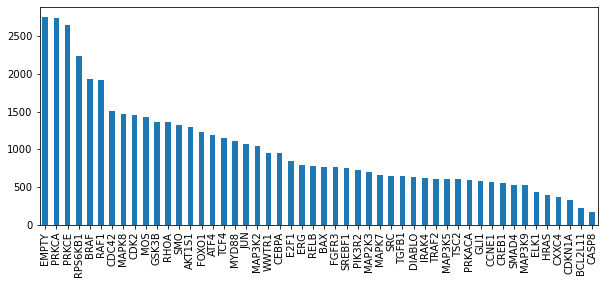

<IPython.core.display.Javascript object>

In [10]:
fold_data["test"][0].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))

<AxesSubplot:>

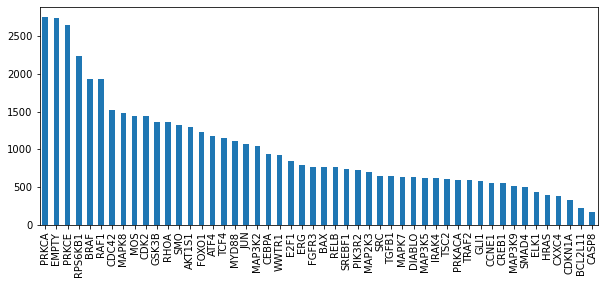

<IPython.core.display.Javascript object>

In [11]:
fold_data["test"][1].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))

<AxesSubplot:>

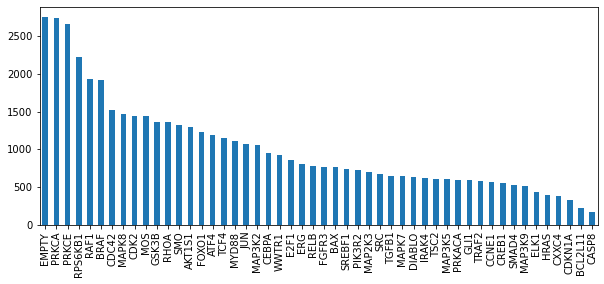

<IPython.core.display.Javascript object>

In [12]:
fold_data["test"][2].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))

<AxesSubplot:>

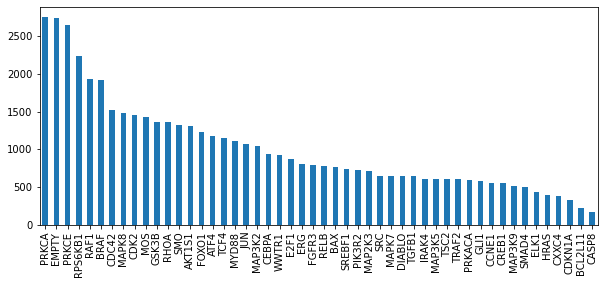

<IPython.core.display.Javascript object>

In [13]:
fold_data["test"][3].gene_symbol.value_counts().plot(kind="bar", figsize=(10, 4))